# Binary Classification of Machine Failures

## Index <a id="index"></a>

- [Libraries](#libraries)
- [Import Data](#import_data)
- [Data Cleaning](#data_cleaning)
- [Exploratory Data Analysis](#eda)
- [Preprocessing](#preprocessing)
- [PCA Analysis](#pca)
- [Model](#model)
- [Save Predictions](#savepreds)

## Libraries <a id="libraries"></a>

[Return to Index](#index)

In [1]:
import os

In [197]:
if 'source' not in os.listdir():
    os.chdir('..')

In [23]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from source.model_toolkit import models as mods

In [161]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [113]:
import lightgbm as lgb

## Import Data <a id="import_data"></a>

[Return to Index](#index)

In [4]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

In [5]:
train_data

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136424,136424,M22284,M,300.1,311.4,1530,37.5,210,0,0,0,0,0,0
136425,136425,H38017,H,297.5,308.5,1447,49.1,2,0,0,0,0,0,0
136426,136426,L54690,L,300.5,311.8,1524,38.5,214,0,0,0,0,0,0
136427,136427,L53876,L,301.7,310.9,1447,46.3,42,0,0,0,0,0,0


## Data Cleaning <a id="data_cleaning"></a>

[Return to Index](#index)

The training data contains **136429** rows.

In [6]:
len(train_data)

136429

In [7]:
train_data.dtypes

id                           int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object

The training data contains **no nulls** on any columnn

In [8]:
pd.isnull(train_data).sum()

id                         0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

**Product ID** column contains **9976** unique values. Each contains less than **1%** rows. We should not use this variable.

In [9]:
train_data['Product ID'].value_counts(normalize = True)

Product ID
L53257    0.001019
L49056    0.000960
L53271    0.000960
L54275    0.000880
L48892    0.000880
            ...   
M24614    0.000007
H39399    0.000007
M15853    0.000007
H32637    0.000007
L48036    0.000007
Name: proportion, Length: 9976, dtype: float64

**Type** column contains **3** unique values, 'L', 'M' and 'H'.

In [10]:
train_data['Type'].value_counts(normalize = True)

Type
L    0.698928
M    0.235668
H    0.065404
Name: proportion, dtype: float64

The dataset is very **unbalanced**. Class balancing must be done.

In [11]:
train_data['Machine failure'].value_counts(normalize = True)

Machine failure
0    0.984256
1    0.015744
Name: proportion, dtype: float64

## Exploratory Data Analysis <a id="eda"></a>

[Return to Index](#index)

Define numerical and categorical columns

In [12]:
train_data.columns

Index(['id', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'],
      dtype='object')

In [13]:
exclude_cols = ['id', 'Product ID', 'Machine failure']

categorical_cols = ['Type', 'TWF', 'HDF' ,'PWF', 'OSF', 'RNF']

numerical_cols = [col for col in train_data.columns if col not in exclude_cols + categorical_cols]

### Numerical Columns

In [14]:
def boxplot_bytarget(df, cols, target_var, **kwargs):
    ylabels = df[target_var].unique()
    
    for i in range(len(cols)):
        fig, ax = plt.subplots()
        ax.boxplot([df[df[target_var] == ylabel][cols[i]] for ylabel in ylabels], **kwargs)
        
        ax.set_ylabel(cols[i])
        ax.set_xlabel(target_var)
        
        ax.set_xticklabels(ylabels)
        
        ax.set_title(f'Boxplot of {cols[i]} by {target_var}') 
        plt.show()

In [15]:
def hist_bytarget(df, cols, target_var, **kwargs):
    ylabels = df[target_var].unique()
    
    for i in range(len(cols)):
        fig, ax = plt.subplots()
        for ylabel in ylabels:
            ax.hist(df[df[target_var] == ylabel][cols[i]], label = ylabel, **kwargs)
        
        ax.set_xlabel(cols[i])
        ax.set_ylabel('Relative Frequency')
        
        ax.legend()
        ax.set_title(f'Histogram of {cols[i]} by {target_var}')
        
        plt.show()

In [16]:
def plot_corrmatrix(df, cols):
    data = df[cols].corr()
    
    fig, ax = plt.subplots()
    
    cax = ax.matshow(data)
    
    ax.set_xticks(range(len(numerical_cols)), labels = numerical_cols, rotation = 45)
    ax.set_yticks(range(len(numerical_cols)), labels = numerical_cols)

    for (i, j), value in np.ndenumerate(data):
        ax.text(i, j, f'{round(value, 2)}')
    
    ax.set_title('Correlation Matrix')
    fig.colorbar(cax)
    
    plt.show()

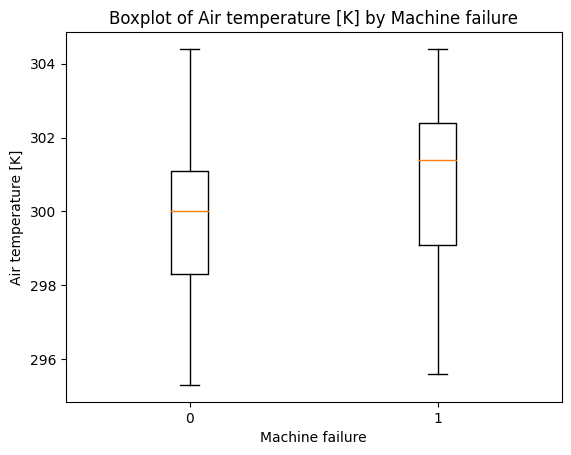

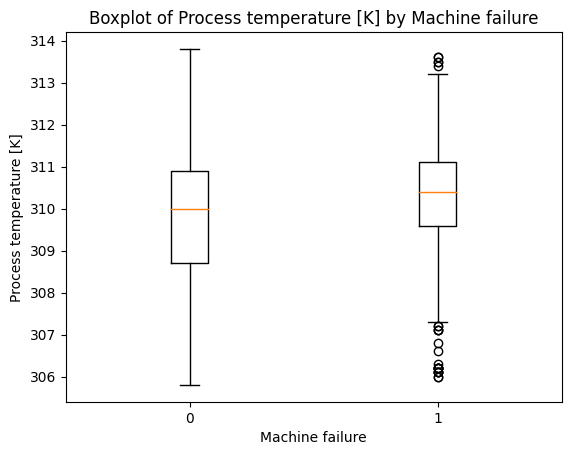

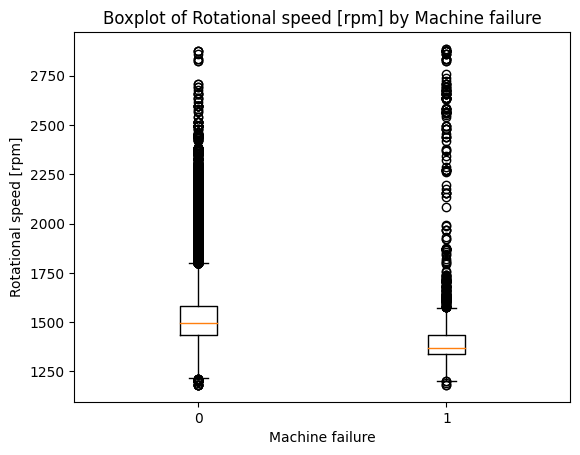

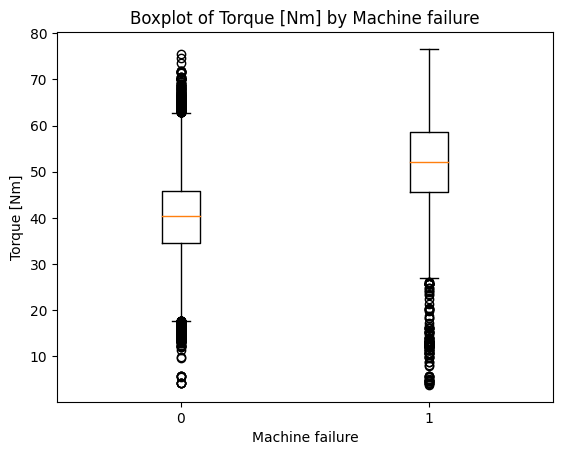

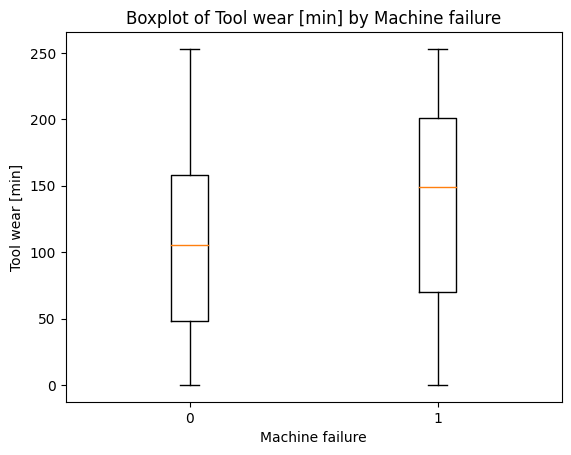

In [17]:
boxplot_bytarget(train_data, numerical_cols, 'Machine failure')

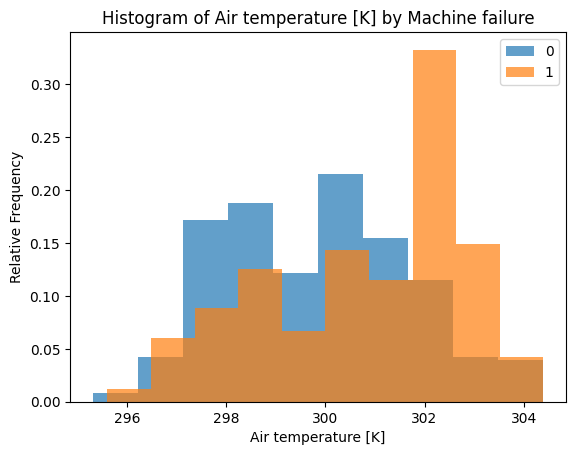

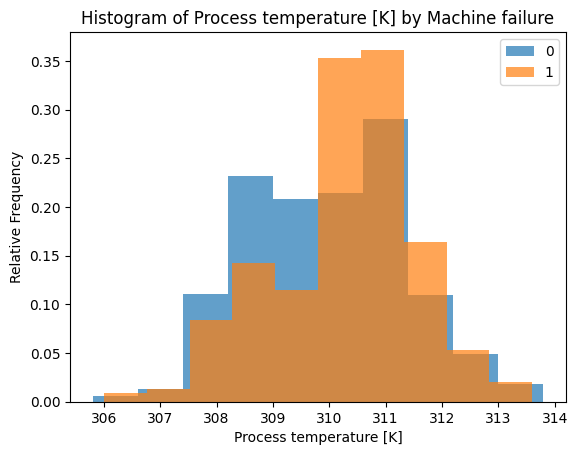

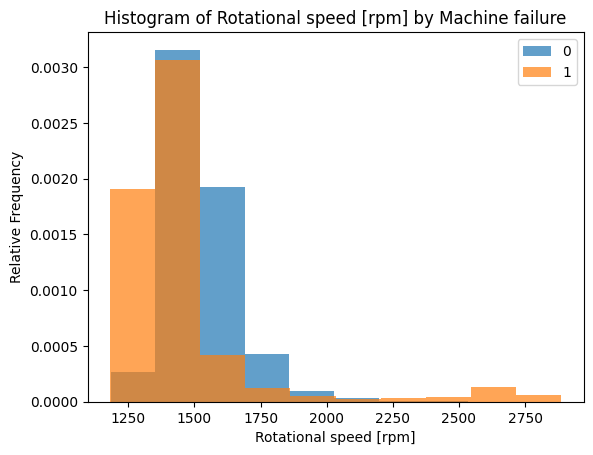

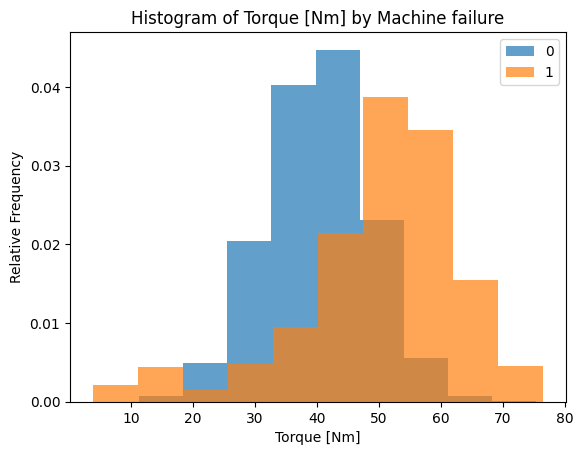

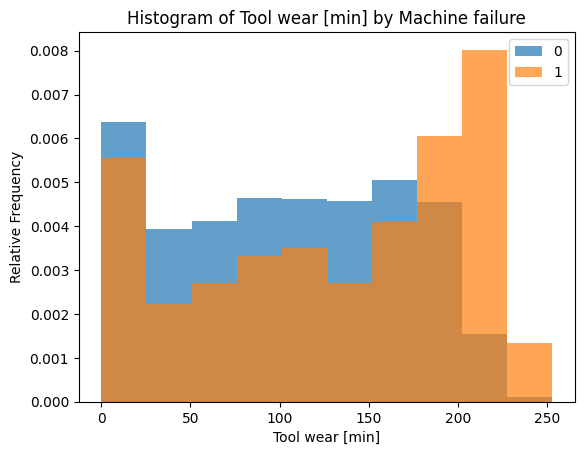

In [18]:
hist_bytarget(train_data, numerical_cols, 'Machine failure', density = True, alpha = 0.7)

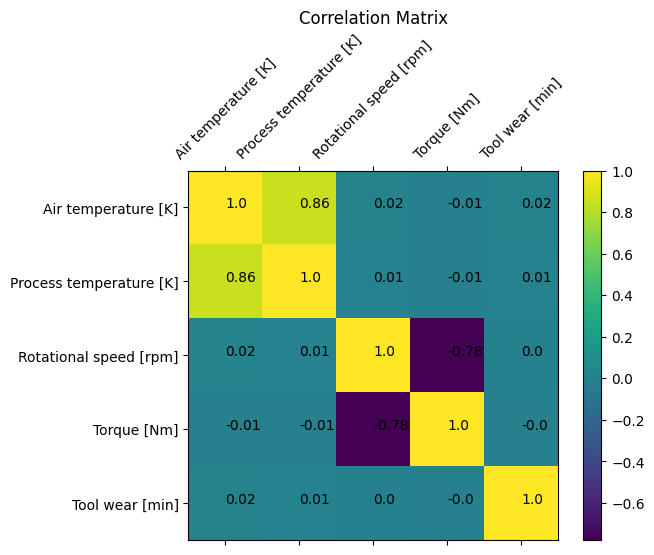

In [19]:
plot_corrmatrix(train_data, numerical_cols)

### Categorical Columns

In [20]:
def bar_bytarget(df, cols, target_var):
    ylabels = df[target_var].unique()
    
    for col in cols:
        xlabels = df[col].unique()
        data = df.groupby(col)[target_var].agg('mean')
        
        fig, ax = plt.subplots()
        
        bax = ax.bar(xlabels, data)
        
        ax.set_xticks(xlabels)
        
        ax.set_xlabel(col)
        ax.set_ylabel(f'Average {target_var}')
        
        ax.set_title(f'Average {target_var} by {col}')
        
        plt.show()

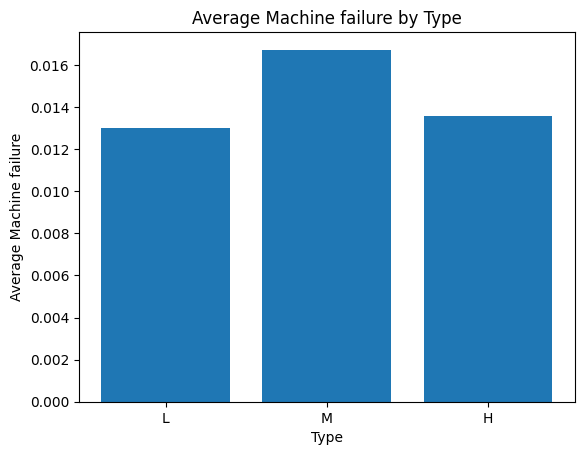

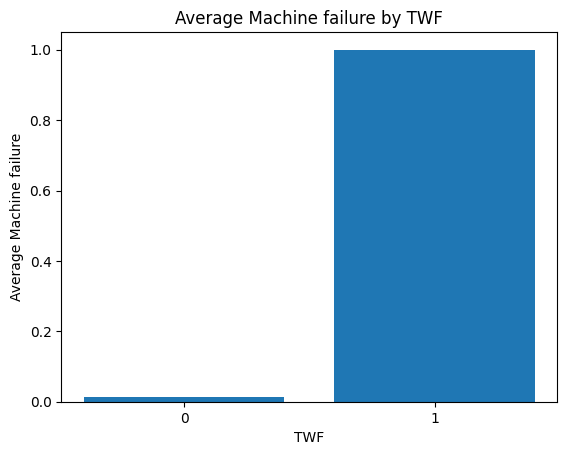

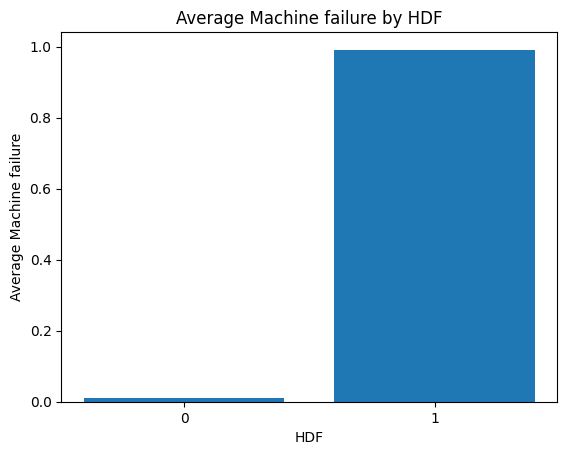

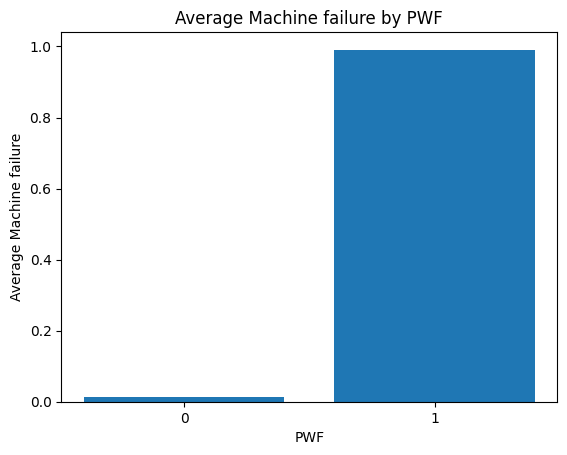

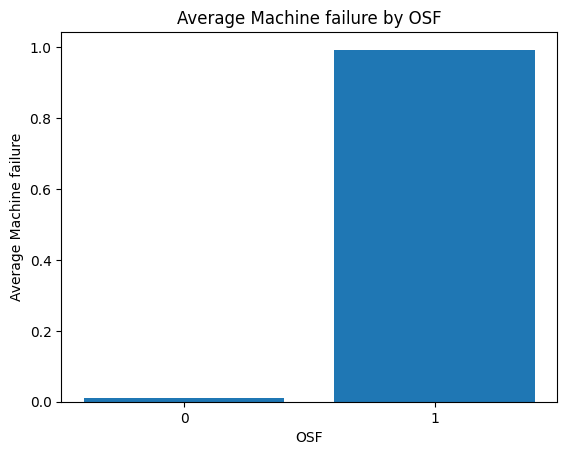

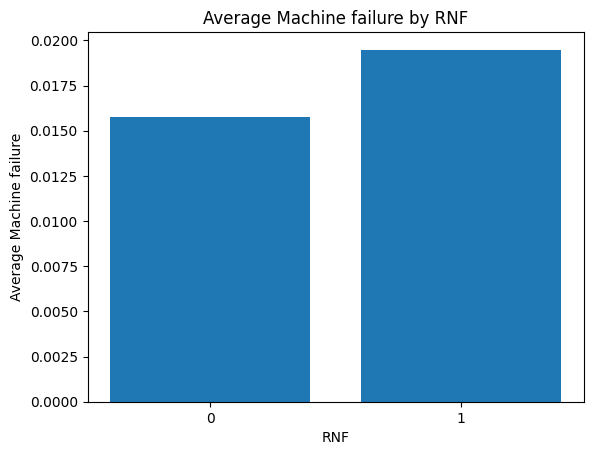

In [21]:
bar_bytarget(train_data, categorical_cols, 'Machine failure')

## Preprocessing <a id="preprocessing"></a>

[Return to Index](#index)

Selection of final columns

In [22]:
categorical_features = categorical_cols
numerical_features = numerical_cols

### Train-Test Split

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    train_data[numerical_features + categorical_features],
    train_data['Machine failure'],
    train_size = 0.7, 
    random_state = 23
)

### Pipeline

In [40]:
modelpipe = {
    'numeric': {
        'vars': numerical_features,
        'impute': SimpleImputer(strategy = 'mean'),
        'scale': StandardScaler()
    },
    'categorical': {
        'vars': categorical_features,
        'impute': SimpleImputer(strategy = 'most_frequent'),
        'encode': OneHotEncoder(handle_unknown = 'ignore', sparse_output = False, drop = 'if_binary')
    }
}

pipeline = mods.get_pipe(**modelpipe)

In [41]:
pipeline.fit(X_train)

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('impute', SimpleImputer()),
                                                 ('scale', StandardScaler())]),
                                 ['Air temperature [K]',
                                  'Process temperature [K]',
                                  'Rotational speed [rpm]', 'Torque [Nm]',
                                  'Tool wear [min]']),
                                ('categorical',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encode',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Type', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'])])

In [42]:
X_train = pipeline.transform(X_train)
X_test = pipeline.transform(X_test)

## PCA Analysis <a id="pca"></a>

[Return to Index](#index)

In [51]:
pca = PCA()
pca.fit(X_train)

PCA()

In [88]:
def plot_PCA(df, y, target_var):
    ylabels = y.unique()
    
    fig, ax = plt.subplots()
    
    for ylabel in ylabels:
        ax.scatter(df[y == ylabel, 0], df[y == ylabel, 1], label = ylabel)
    
    ax.set_xlabel('First Principal Component')
    ax.set_ylabel('Second Principal Component')
    
    ax.legend()
    ax.set_title(f'First 2 Principal components by {target_var}')
    
    plt.show()    

We'll plot the first two Principal Components

There doesn't to be a distinct boundary between the classes but the values of each respective class seem to be mostly grouped together. KNN could work well to predict class

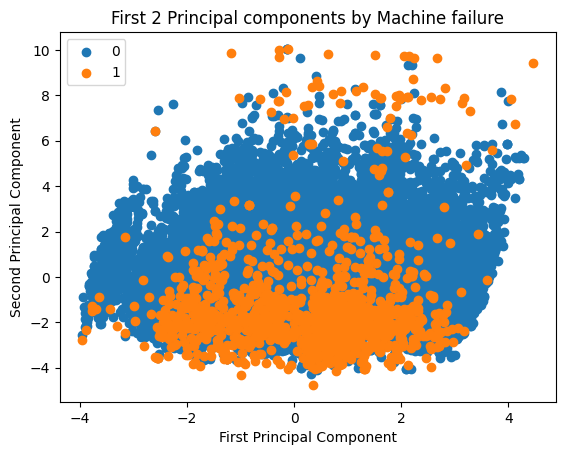

In [89]:
plot_PCA(pca.transform(X_train), y_train, 'Machine failure')

As we plot the Explained variance of the PCA, we can see that the first four components explain more than 90% of the variance.

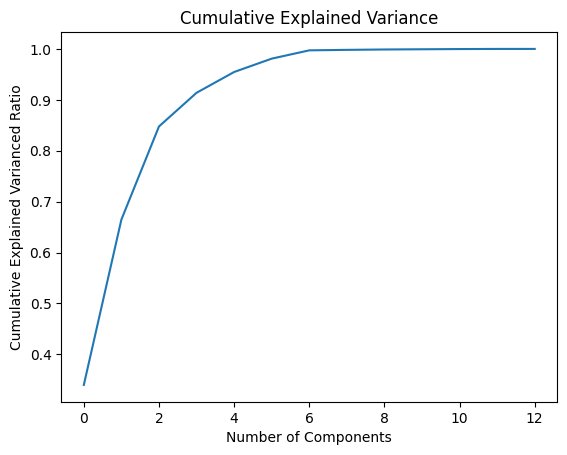

In [90]:
fig, ax = plt.subplots()

ax.plot(pca.explained_variance_ratio_.cumsum())

ax.set_xlabel('Number of Components')
ax.set_ylabel('Cumulative Explained Varianced Ratio')

ax.set_title('Cumulative Explained Variance')

plt.show()

## Model <a id="model"></a>

- [K Nearest Neighbors](#knn)
- [LightGBM](#lightgbm)
- [Final Model](#finalmodel)
- [Evaluate Model](#evaluate)

[Return to Index](#index)

We create a cv instance to train our models

In [98]:
cv = KFold(n_splits = 5, shuffle = True, random_state = 23)

### K Nearest Neighbors <a id="knn"></a>

[Back to Model](#model)

In [99]:
knn_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}

In [101]:
knn = GridSearchCV(
    estimator = KNeighborsClassifier(),
    param_grid = knn_grid,
    scoring = 'average_precision',
    cv = cv,
    refit = True
)

In [102]:
knn.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=23, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7],
                         'weights': ['uniform', 'distance']},
             scoring='average_precision')

In [105]:
print(knn.best_params_)

{'n_neighbors': 7, 'weights': 'distance'}


In [106]:
best_knn = knn.best_estimator_

ROC AUC

In [110]:
roc_auc_score(y_test, best_knn.predict_proba(X_test)[:, 1])

0.8715614506246534

PR AUC

In [111]:
average_precision_score(y_test, best_knn.predict_proba(X_test)[:, 1])

0.7071468618838689

### LightGBM <a id="lightgbm"></a>

[Back to Model](#model)

In [124]:
lgbm_grid = [
    {
        'max_depth': [-1],
        'num_leaves': [50, 75, 100],
        'subsample': [0.5, 0.7, 1],
        'colsample_bytree': [0.6, 0.8, 1],
        'max_bin': [150, 200, 255],
        'learning_rate': [0.1],
        'n_estimators': [50, 70, 100]
    },
    {
        'max_depth': [3],
        'num_leaves': [10, 20, 30],
        'subsample': [0.5, 0.7, 1],
        'colsample_bytree': [0.6, 0.8, 1],
        'max_bin': [150, 200, 255],
        'learning_rate': [0.1],
        'n_estimators': [50, 70, 100]
    },
    {
        'max_depth': [5],
        'num_leaves': [20, 30, 40],
        'subsample': [0.5, 0.7, 1],
        'colsample_bytree': [0.6, 0.8, 1],
        'max_bin': [150, 200, 255],
        'learning_rate': [0.1],
        'n_estimators': [50, 70, 100]
    },
    {
        'max_depth': [7],
        'num_leaves': [30, 40, 50],
        'subsample': [0.5, 0.7, 1],
        'colsample_bytree': [0.6, 0.8, 1],
        'max_bin': [150, 200, 255],
        'learning_rate': [0.1],
        'n_estimators': [50, 70, 100]
    },
    {
        'max_depth': [-1],
        'num_leaves': [50, 75, 100],
        'subsample': [0.5, 0.7, 1],
        'colsample_bytree': [0.6, 0.8, 1],
        'max_bin': [150, 200, 255],
        'learning_rate': [0.05],
        'n_estimators': [70, 100, 120]
    },
    {
        'max_depth': [3],
        'num_leaves': [10, 20, 30],
        'subsample': [0.5, 0.7, 1],
        'colsample_bytree': [0.6, 0.8, 1],
        'max_bin': [150, 200, 255],
        'learning_rate': [0.05],
        'n_estimators': [70, 100, 120]
    },
    {
        'max_depth': [5],
        'num_leaves': [20, 30, 40],
        'subsample': [0.5, 0.7, 1],
        'colsample_bytree': [0.6, 0.8, 1],
        'max_bin': [150, 200, 255],
        'learning_rate': [0.05],
        'n_estimators': [70, 100, 120]
    },
    {
        'max_depth': [7],
        'num_leaves': [30, 40, 50],
        'subsample': [0.5, 0.7, 1],
        'colsample_bytree': [0.6, 0.8, 1],
        'max_bin': [150, 200, 255],
        'learning_rate': [0.05],
        'n_estimators': [70, 100, 120]
    },
    {
        'max_depth': [-1],
        'num_leaves': [50, 75, 100],
        'subsample': [0.5, 0.7, 1],
        'colsample_bytree': [0.6, 0.8, 1],
        'max_bin': [150, 200, 255],
        'learning_rate': [0.1],
        'n_estimators': [50, 70, 100]
    },
    {
        'max_depth': [3],
        'num_leaves': [10, 20, 30],
        'subsample': [0.5, 0.7, 1],
        'colsample_bytree': [0.6, 0.8, 1],
        'max_bin': [150, 200, 255],
        'learning_rate': [0.01],
        'n_estimators': [100, 120, 150]
    },
    {
        'max_depth': [5],
        'num_leaves': [20, 30, 40],
        'subsample': [0.5, 0.7, 1],
        'colsample_bytree': [0.6, 0.8, 1],
        'max_bin': [150, 200, 255],
        'learning_rate': [0.01],
        'n_estimators': [100, 120, 150]
    },
    {
        'max_depth': [7],
        'num_leaves': [30, 40, 50],
        'subsample': [0.5, 0.7, 1],
        'colsample_bytree': [0.6, 0.8, 1],
        'max_bin': [150, 200, 255],
        'learning_rate': [0.01],
        'n_estimators': [100, 120, 150]
    },
]

In [125]:
lgbm = RandomizedSearchCV(
    lgb.LGBMClassifier(random_state = 23, is_unbalance = True),
    param_distributions = lgbm_grid,
    scoring = 'average_precision',
    cv = cv,
    random_state = 23,
    refit = True
)

In [126]:
lgbm.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=23, shuffle=True),
                   estimator=LGBMClassifier(is_unbalance=True, random_state=23),
                   param_distributions=[{'colsample_bytree': [0.6, 0.8, 1],
                                         'learning_rate': [0.1],
                                         'max_bin': [150, 200, 255],
                                         'max_depth': [-1],
                                         'n_estimators': [50, 70, 100],
                                         'num_leaves': [50, 75, 100],
                                         'subsample': [0.5, 0.7, 1]},
                                        {'colsample_bytree': [0.6, 0.8...
                                         'learning_rate': [0.01],
                                         'max_bin': [150, 200, 255],
                                         'max_depth': [5],
                                         'n_estimators': [100, 120, 150],
                                         'num_leaves': [20, 30, 40],
                                         'subsample': [0.5, 0.7, 1]},
                                        {'colsample_bytree': [0.6, 0.8, 1],
                                         'learning_rate': [0.01],
                                         'max_bin': [150, 200, 255],
                                         'max_depth': [7],
                                         'n_estimators': [100, 120, 150],
                                         'num_leaves': [30, 40, 50],
                                         'subsample': [0.5, 0.7, 1]}],
                   random_state=23, scoring='average_precision')

In [129]:
print(lgbm.best_params_)

{'subsample': 1, 'num_leaves': 20, 'n_estimators': 100, 'max_depth': 3, 'max_bin': 150, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


In [130]:
best_lgbm = lgbm.best_estimator_

ROC AUC

In [131]:
roc_auc_score(y_test, best_lgbm.predict_proba(X_test)[:, 1])

0.9671140212722927

PR AUC

In [132]:
average_precision_score(y_test, best_lgbm.predict_proba(X_test)[:, 1])

0.8330188032826221

### Final Model <a id="finalmodel"></a>

[Back to Model](#model)

In [141]:
final_model = StackingClassifier(
    estimators = [
        ('K Nearest Neighbors', KNeighborsClassifier(**best_knn.get_params())),
        ('LightGBM', lgb.LGBMClassifier(**best_lgbm.get_params()))
    ],
    cv = KFold(n_splits = 5, shuffle = True, random_state = 42)
)

In [142]:
final_model.fit(X_train, y_train)

StackingClassifier(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimators=[('K Nearest Neighbors',
                                KNeighborsClassifier(n_neighbors=7,
                                                     weights='distance')),
                               ('LightGBM',
                                LGBMClassifier(colsample_bytree=0.8,
                                               is_unbalance=True, max_bin=150,
                                               max_depth=3, num_leaves=20,
                                               random_state=23, subsample=1))])

### Evaluate Model <a id="evaluate"></a>

[Back to Model](#model)

In [147]:
ypred = final_model.predict_proba(X_test)[:, 1]

#### Confusion Matrix

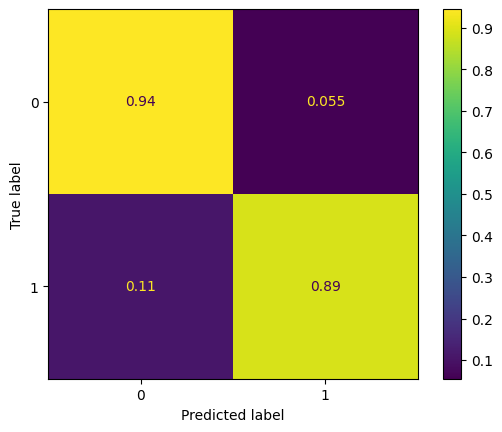

In [156]:
mods.plot_confusion_matrix(
    y_test, 
    ypred, 
    cutoff = np.sum(y_train[y_train == 1]) / len(y_train)
)

#### ROC Curve

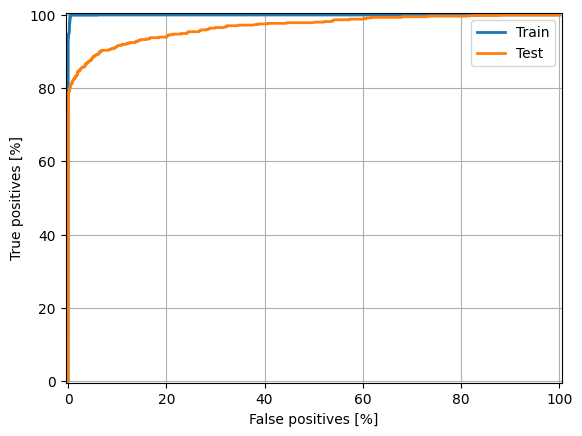

In [160]:
mods.plot_roc('Train', y_train, final_model.predict_proba(X_train)[:, 1])
mods.plot_roc('Test', y_test, ypred)
plt.legend()

#### ROC AUC

In [172]:
roc_auc_score(y_test, ypred)

0.9677660593372703

#### PR Curve

In [164]:
train_pr, train_re, _ = precision_recall_curve(y_train, final_model.predict_proba(X_train)[:, 1])
test_pr, test_re, _ = precision_recall_curve(y_test, ypred)

In [169]:
def plot_pr(names, precisions, recalls):
    fig, ax = plt.subplots()
    
    for (name, precision, recall) in zip(names, precisions, recalls):
        ax.plot(100*precision, 100*recall, label = name)
    
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    
    ax.set_title('Precision-Recall Curve')
    ax.legend()
    
    plt.show()

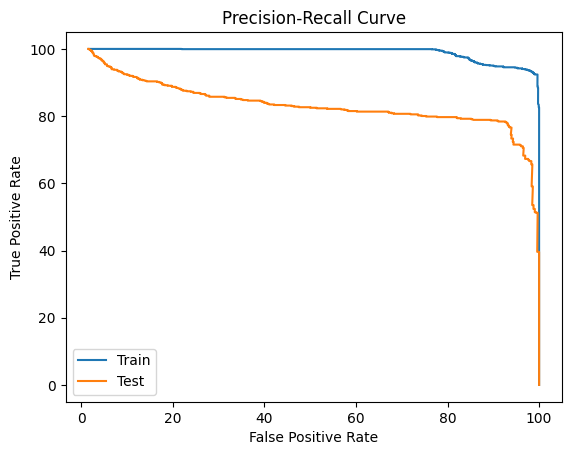

In [170]:
plot_pr(['Train', 'Test'], [train_pr, test_pr], [train_re, test_re])

#### PR AUC

In [174]:
average_precision_score(y_test, ypred)

0.8343680523557406

### Save Predictions <a id="savepreds"></a>

[Back to Model](#model)

In [184]:
test_data

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
0,136429,L50896,L,302.3,311.5,1499,38.0,60,0,0,0,0,0
1,136430,L53866,L,301.7,311.0,1713,28.8,17,0,0,0,0,0
2,136431,L50498,L,301.3,310.4,1525,37.7,96,0,0,0,0,0
3,136432,M21232,M,300.1,309.6,1479,47.6,5,0,0,0,0,0
4,136433,M19751,M,303.4,312.3,1515,41.3,114,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
90949,227378,L51130,L,302.3,311.4,1484,40.4,15,0,0,0,0,0
90950,227379,L47783,L,297.9,309.8,1542,33.8,31,0,0,0,0,0
90951,227380,L48097,L,295.6,306.2,1501,41.4,187,0,0,0,0,0
90952,227381,L48969,L,298.1,307.8,1534,40.3,69,0,0,0,0,0


In [179]:
X = test_data[numerical_features + categorical_features]

In [180]:
X = pipeline.transform(X)

In [182]:
y = final_model.predict_proba(X)[:, 1]

In [188]:
prediction = pd.DataFrame(
    {
        'id': test_data['id'],
        'Machine failure': y
    }
)

In [191]:
prediction.to_csv('predictions/prediction.csv', index = False)